In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.svm import SVR
from sklearn.model_selection import cross_val_score, cross_validate, cross_val_predict, GridSearchCV, train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import KFold
from xgboost import XGBRegressor
from tqdm import tqdm
from utils import *
import warnings
warnings.filterwarnings("ignore")

In [2]:
INPUT_VARS = ['x_' + str(i) for i in range(1, 10 + 1)]
RESPONSE_VARS = ['y']

''' Read data & split to train / test '''
data_A = pd.read_csv('data/ART/data_A.csv', index_col=0)
data_B = pd.read_csv('data/ART/data_B.csv', index_col=0)
data_C = pd.read_csv('data/ART/data_C.csv', index_col=0)
data_AB = pd.concat([data_A, data_B], axis=0)

X_A = data_A[INPUT_VARS]
y_A = data_A[RESPONSE_VARS]
X_B = data_B[INPUT_VARS]
y_B = data_B[RESPONSE_VARS]
X_C = data_C[INPUT_VARS]
y_C = data_C[RESPONSE_VARS]

print(f'X_A shape: {X_A.shape} \nX_B shape: {X_B.shape} \nX_C shape: {X_C.shape}')

X_A shape: (100, 10) 
X_B shape: (16, 10) 
X_C shape: (16, 10)


### OMLT

In [59]:
from omlt import OmltBlock, OffsetScaling
from omlt.io.keras import load_keras_sequential
from omlt.neuralnet import ReluBigMFormulation, FullSpaceSmoothNNFormulation
import pyomo.environ as pyo
import pandas as pd
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint

In [60]:
dfin = X_A
dfout = y_A

inputs = INPUT_VARS
outputs = RESPONSE_VARS

x_offset, x_factor = dfin.mean().to_dict(), dfin.std().to_dict()
y_offset, y_factor = dfout.mean().to_dict(), dfout.std().to_dict()

dfin = (dfin - dfin.mean()).divide(dfin.std())
dfout = (dfout - dfout.mean()).divide(dfout.std())

x = dfin.values
y = dfout.values

# capture the minimum and maximum values of the scaled inputs so we don't use the model outside the valid range
scaled_lb = dfin.min()[inputs].values
scaled_ub = dfin.max()[inputs].values

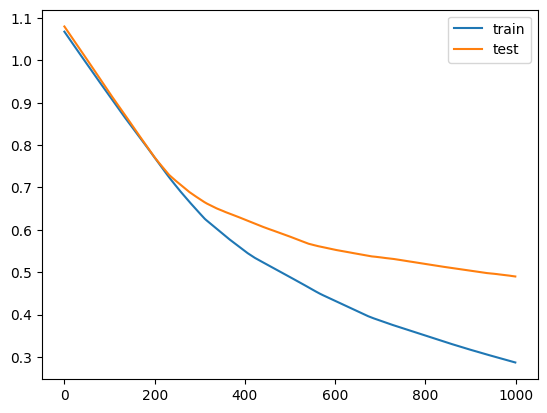

In [132]:
sgd = tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9, nesterov=True)
adam = tf.keras.optimizers.Adam(learning_rate=0.0001)
# create our Keras Sequential model
nn = Sequential(name='ANN')
nn.add(Dense(units=64, input_dim=len(inputs), activation='relu'))
# nn.add(Dense(units=25, activation='relu'))
nn.add(Dense(1))
nn.compile(optimizer=adam, loss='mean_absolute_error', metrics=['mean_absolute_error'])

history = nn.fit(x, y, epochs=1000, validation_split=0.33, verbose=0, batch_size=100)

# plot training history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [133]:
# first, create the Pyomo model
m = pyo.ConcreteModel()
# create the OmltBlock to hold the neural network model
m.reformer = OmltBlock()
# load the Keras model
nn_reformer = nn

# Note: The neural network is in the scaled space. We want access to the
# variables in the unscaled space. Therefore, we need to tell OMLT about the
# scaling factors
scaler = OffsetScaling(
        offset_inputs={i: x_offset[inputs[i]] for i in range(len(inputs))},
        factor_inputs={i: x_factor[inputs[i]] for i in range(len(inputs))},
        offset_outputs={i: y_offset[outputs[i]] for i in range(len(outputs))},
        factor_outputs={i: y_factor[outputs[i]] for i in range(len(outputs))}
    )

scaled_input_bounds = {i: (scaled_lb[i], scaled_ub[i]) for i in range(len(inputs))}

# create a network definition from the Keras model
net = load_keras_sequential(nn_reformer, scaling_object=scaler, scaled_input_bounds=scaled_input_bounds)

# create the variables and constraints for the neural network in Pyomo
m.reformer.build_formulation(ReluBigMFormulation(net))

# now add the objective and the constraints
y_idx = outputs.index('y')
m.obj = pyo.Objective(expr=m.reformer.outputs[y_idx], sense=pyo.maximize)

# now solve the optimization problem (this may take some time)
solver = pyo.SolverFactory('gurobi')
status = solver.solve(m, tee=False)

for i in range(len(inputs)):
    print(f'{inputs[i]}:', pyo.value(m.reformer.inputs[i]))

print('y: ', pyo.value(m.reformer.outputs[y_idx]))

x_1: 9.856609879235558
x_2: 9.87779152755003
x_3: 9.931190516641252
x_4: 6.729897476696174
x_5: 9.856837773692291
x_6: 9.991895633476839
x_7: -4.8790002420459775
x_8: 9.894491872323561
x_9: 6.444032938919044
x_10: 9.87548306098286
y:  27.400816344357608


In [134]:
data_B

,x_1,x_2,x_3,x_4,x_5,x_6,x_7,x_8,x_9,x_10,y
100,4.507433,8.006332,4.875679,3.146383,5.639381,6.523150,4.064956,5.070539,6.828734,4.151392,22.959551
101,4.367828,2.841366,3.937315,4.613106,6.709210,6.404722,5.999672,4.664339,2.619694,6.557923,22.956203
102,6.768144,6.612963,3.278946,4.108199,8.057984,5.632422,3.975182,5.210836,5.557407,5.576319,22.902591
103,4.029073,3.784677,5.387136,4.859869,5.156912,3.024582,5.654005,7.408791,4.128099,2.385368,22.965737
104,4.688820,7.911141,4.433306,2.138053,6.046514,6.574903,4.435609,4.393314,6.263750,4.885011,22.704414
105,6.794419,3.597942,6.010257,5.358676,5.485666,4.407843,6.154090,3.853369,1.687204,6.070541,22.831115
106,4.117719,4.883424,1.827686,6.701664,6.951539,5.925168,3.822645,5.148735,5.107771,7.311039,22.482351
107,6.592608,7.909701,5.322837,3.839400,2.379341,5.615624,5.127491,4.982311,7.271020,4.208987,22.449938
108,4.941347,7.255061,6.729557,2.882445,2.800508,6.326327,5.072361,4.757553,7.297742,3.696675,22.379665
109,4.618514,5.283968,3.373324,3.969757,1.593527,2.956348,4.695073,2.725101,4.204636,3.528698,22.222030
